# KB-CAPTCHA Machine Learning Design Documentation

## Before you start
If you would like to use a new random sample for the data in this document, click the first cell with Python code in this document, then navigate to the *run* dropdown in the Jupyter Notebook interface. Then, click the *Run Selected Cell and All Below* option. There is a chance this will cause errors because some of the raw data from the set has formatting errors. These are fixed and/or ignored by the Lua parsing script, but remain in the raw data used by the notebook folder. If one of these files is selected by random chance, it can cause an error. Simply re-run the notebook as described above to fix the issue.

## Overview
This notebook is meant to serve as documentation for the rationale and processes for the design of this project with regard to its data analysis.
For instructions on running the solution, installation and clean-up, please see the README at the root of the project files.

## Hypothesis
Users can successfully be distinguished from a large class of bots based on the typing metrics of `average key held time`, `average keystroke delay time`, `key overlap percentage` and `standard deviation of the first two values` using unsupervised machine learning techniques.

## Data Set Description
We will source the data for this project from the "136M Keystrokes" data set available [here](https://userinterfaces.aalto.fi/136Mkeystrokes/). This data set contains the following fields:

* Participant id (Integer)
* Test section id (Integer)
* Sentence (String)
* User input (String)
* Keystroke id (Integer)
* Press time (Integer)
* Release time (Integer)
* Letter (String)
* Keycode (Integer)

To test our hypothesis, we need to extract and convert the data from these fields. 

* Average key held time
* Standard deviation of key held time
    * We can derive both of these fields by subtracting the "Press time" from the "Release time" of each entry and then taking the average / standard deviation of the results.
* Average time between keystrokes
* Standard deviation of time between strokes
    * Both of these fields can be derived by subtracting the "Press time" of the current key from the "Press time" of the previous key and taking the average / standard deviation of the results.
* Percentage of keys pressed while the previous key is still held down
    * We can determine if a given key is an "overlap" key by checking if its "Press time" is before the previous key's "Release time". Then, add up overlap keys and divide by the total.

## Data Set Exploration

To explore the viability of standard deviation as a measure of spread as well as identify outliers, we will visualize a random sample of the data and try to make observations and generalizations.

First, let's visualize the distributions for key held time.

### Key Held Time



Generating sample charts. This can take a while.
Selecting file ../Data/raw/374013_keystrokes.txt
Selecting file ../Data/raw/394642_keystrokes.txt
Selecting file ../Data/raw/346164_keystrokes.txt
Selecting file ../Data/raw/174505_keystrokes.txt


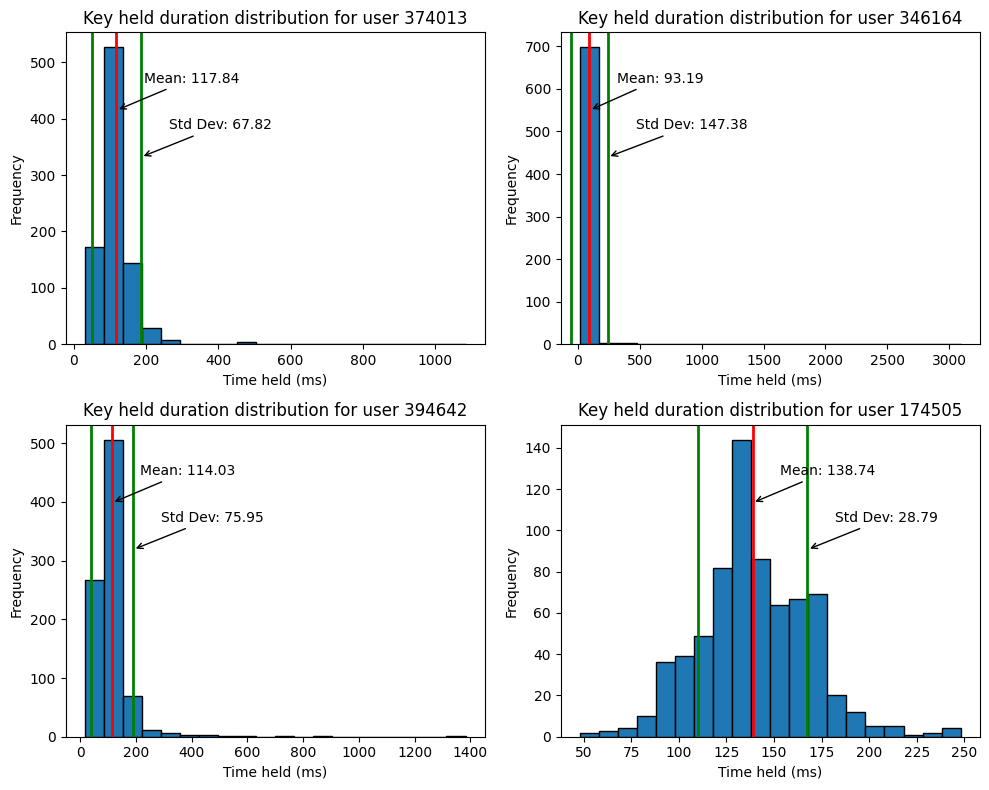

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import random
import re
%matplotlib inline 

print("Generating sample charts. This can take a while.")

#The product of these two should equal the 
graph_row_count = 2
graph_col_count = 2
number_of_samples = graph_row_count * graph_col_count
graph_size_x = 10
graph_size_y = 8


directory = "../Data/raw/"
all_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]

files_to_show = []
for i in range(number_of_samples):
    file_to_add = os.path.join(directory, random.choice(all_files))
    print(f"Selecting file {file_to_add}")
    files_to_show.append(file_to_add)


figure, subplot = plt.subplots(nrows=graph_row_count, ncols=graph_col_count, figsize=(graph_size_x, graph_size_y))

graph_row = 0
graph_col = 0

for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["TIME_HELD"] = data_frame["RELEASE_TIME"] - data_frame["PRESS_TIME"]
    
    time_held_std_dev = data_frame["TIME_HELD"].std()
    time_held_mean = data_frame["TIME_HELD"].mean()

    subplot[graph_row][graph_col].hist(data_frame['TIME_HELD'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    subplot[graph_row][graph_col].set_title(f'Key held duration distribution for user {user_id}')
    subplot[graph_row][graph_col].set_xlabel('Time held (ms)')
    subplot[graph_row][graph_col].set_ylabel('Frequency')

    subplot[graph_row][graph_col].axvline(time_held_mean, color='red', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Mean: {time_held_mean:.2f}', xy=(time_held_mean, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    subplot[graph_row][graph_col].axvline(time_held_mean + time_held_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].axvline(time_held_mean - time_held_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Std Dev: {time_held_std_dev:.2f}', xy=(time_held_mean + time_held_std_dev, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))


    graph_row += 1

    if graph_row >= graph_row_count:
        graph_col += 1
        graph_row %= graph_row_count

plt.tight_layout()
plt.show()


Let's remove outliers. To do this, we will remove data points where the key is held for more than 500 milliseconds.

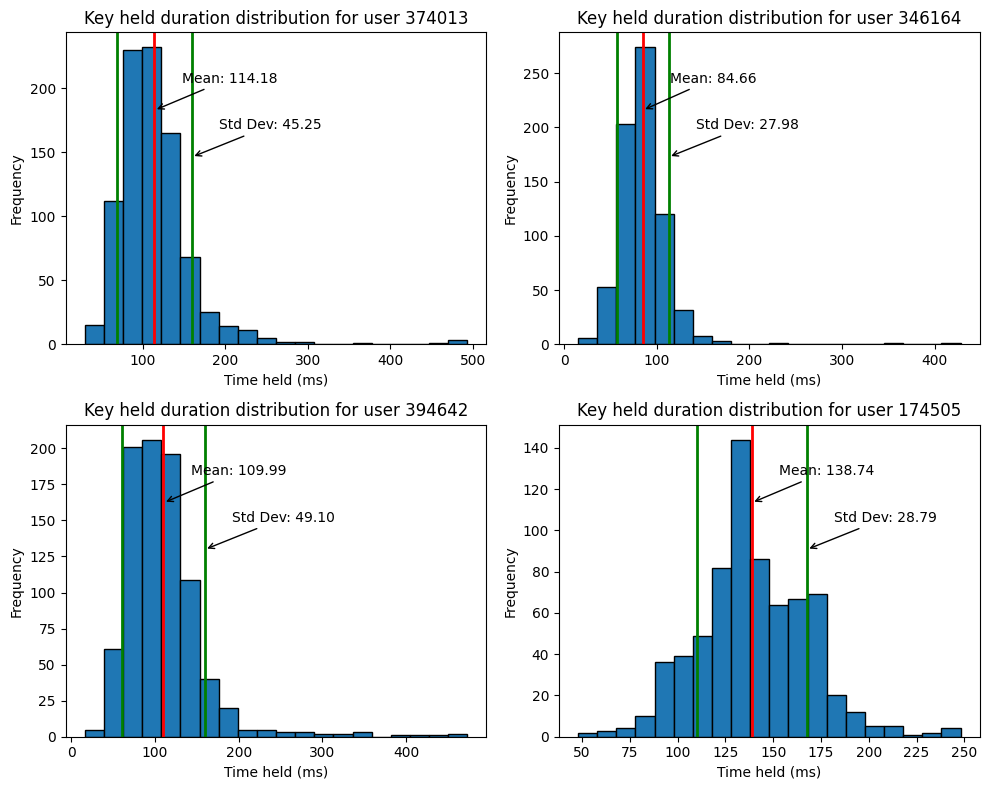

In [2]:
figure, subplot = plt.subplots(nrows=graph_row_count, ncols=graph_col_count, figsize=(graph_size_x, graph_size_y))

graph_row = 0
graph_col = 0

for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["TIME_HELD"] = data_frame["RELEASE_TIME"] - data_frame["PRESS_TIME"]
    data_frame = data_frame.query("TIME_HELD <= 500")
    time_held_std_dev = data_frame["TIME_HELD"].std()
    time_held_mean = data_frame["TIME_HELD"].mean()

    subplot[graph_row][graph_col].hist(data_frame['TIME_HELD'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    subplot[graph_row][graph_col].set_title(f'Key held duration distribution for user {user_id}')
    subplot[graph_row][graph_col].set_xlabel('Time held (ms)')
    subplot[graph_row][graph_col].set_ylabel('Frequency')

    subplot[graph_row][graph_col].axvline(time_held_mean, color='red', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Mean: {time_held_mean:.2f}', xy=(time_held_mean, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    subplot[graph_row][graph_col].axvline(time_held_mean + time_held_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].axvline(time_held_mean - time_held_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Std Dev: {time_held_std_dev:.2f}', xy=(time_held_mean + time_held_std_dev, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))
    

    graph_row += 1

    if graph_row >= graph_row_count:
        graph_col += 1
        graph_row %= graph_row_count
        
plt.tight_layout()
plt.show()

This seems to produce much better results. We don't want to exclude much more than this however, as a very slow typist may have data that is shifted to the right toward the 500 millisecond cutoff.

Now, lets observe how the distributions for time between strokes looks.

### Time Between Strokes

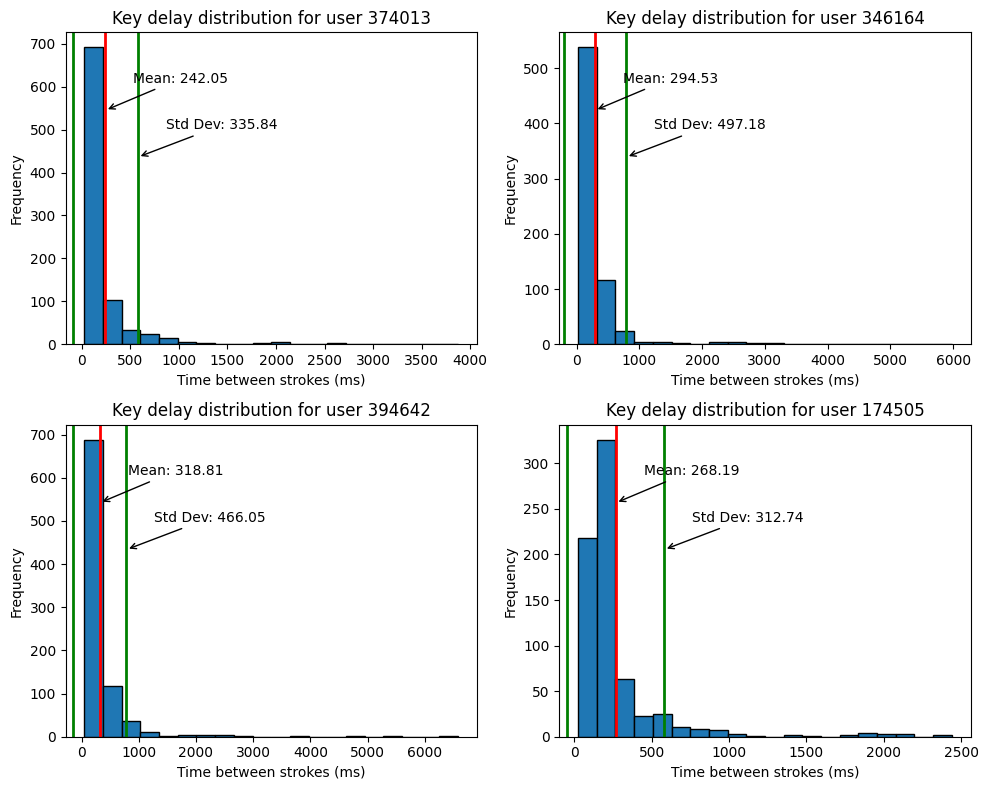

In [3]:
figure, subplot = plt.subplots(nrows=graph_row_count, ncols=graph_col_count, figsize=(graph_size_x, graph_size_y))

graph_row = 0
graph_col = 0

for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["KEY_DELAY"] = data_frame["PRESS_TIME"].shift(-1) - data_frame["PRESS_TIME"]
    
    key_delay_std_dev = data_frame["KEY_DELAY"].std()
    key_delay_mean = data_frame["KEY_DELAY"].mean()
    
    subplot[graph_row][graph_col].hist(data_frame['KEY_DELAY'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    subplot[graph_row][graph_col].set_title(f'Key delay distribution for user {user_id}')
    subplot[graph_row][graph_col].set_xlabel('Time between strokes (ms)')
    subplot[graph_row][graph_col].set_ylabel('Frequency')

    subplot[graph_row][graph_col].axvline(key_delay_mean, color='red', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Mean: {key_delay_mean:.2f}', xy=(key_delay_mean, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    subplot[graph_row][graph_col].axvline(key_delay_mean + key_delay_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].axvline(key_delay_mean - key_delay_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Std Dev: {key_delay_std_dev:.2f}', xy=(key_delay_mean + key_delay_std_dev, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))
    
    graph_row += 1

    if graph_row >= graph_row_count:
        graph_col += 1
        graph_row %= graph_row_count

plt.tight_layout()
plt.show()

These are unfortunately not very informative due to the extreme outliers. Let's do the same visualization, but remove all entries with more than 1 second of loiter time.


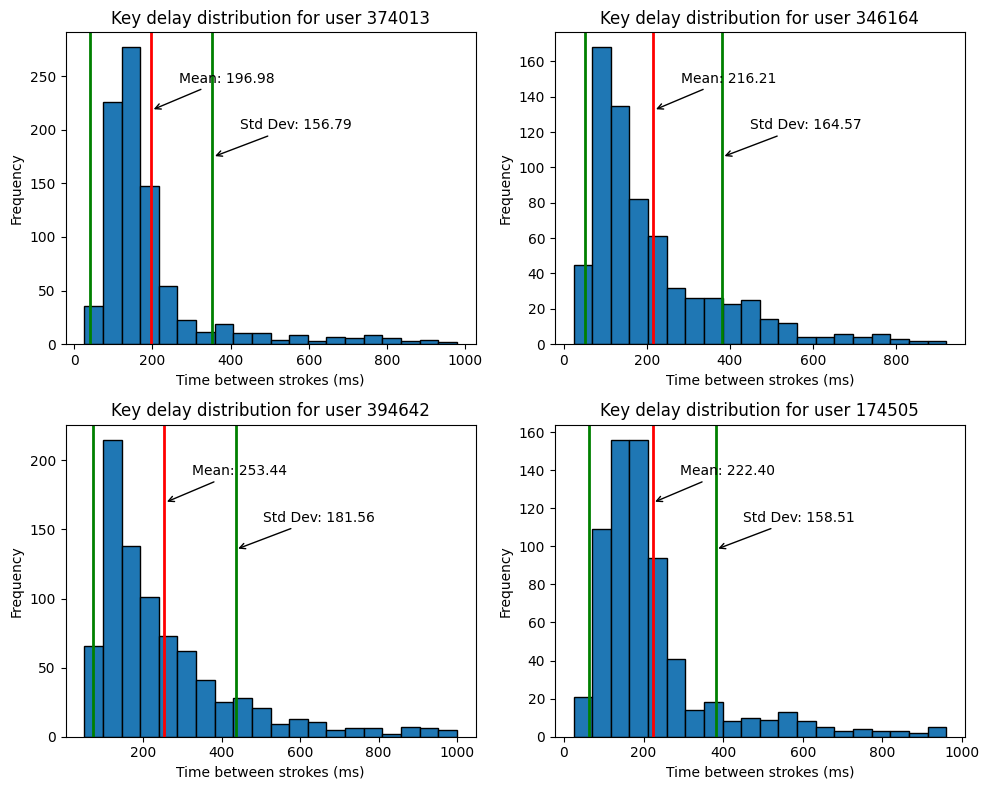

In [4]:
figure, subplot = plt.subplots(nrows=graph_row_count, ncols=graph_col_count, figsize=(graph_size_x, graph_size_y))

graph_row = 0
graph_col = 0

for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["KEY_DELAY"] = data_frame["PRESS_TIME"].shift(-1) - data_frame["PRESS_TIME"]
    data_frame = data_frame.query("KEY_DELAY <= 1000")
    data_frame = data_frame.query("KEY_DELAY > 0")
    
    key_delay_std_dev = data_frame["KEY_DELAY"].std()
    key_delay_mean = data_frame["KEY_DELAY"].mean()
    
    subplot[graph_row][graph_col].hist(data_frame['KEY_DELAY'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    subplot[graph_row][graph_col].set_title(f'Key delay distribution for user {user_id}')
    subplot[graph_row][graph_col].set_xlabel('Time between strokes (ms)')
    subplot[graph_row][graph_col].set_ylabel('Frequency')

    subplot[graph_row][graph_col].axvline(key_delay_mean, color='red', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Mean: {key_delay_mean:.2f}', xy=(key_delay_mean, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    subplot[graph_row][graph_col].axvline(key_delay_mean + key_delay_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].axvline(key_delay_mean - key_delay_std_dev, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Std Dev: {key_delay_std_dev:.2f}', xy=(key_delay_mean + key_delay_std_dev, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))
    
    graph_row += 1

    if graph_row >= graph_row_count:
        graph_col += 1
        graph_row %= graph_row_count
    
plt.tight_layout()
plt.show()


We can see that the data is roughly normal shaped, though does have a non-negligible positive skew. To get a more representative description of the data, let's try using the interquartile range (IQR) instead.

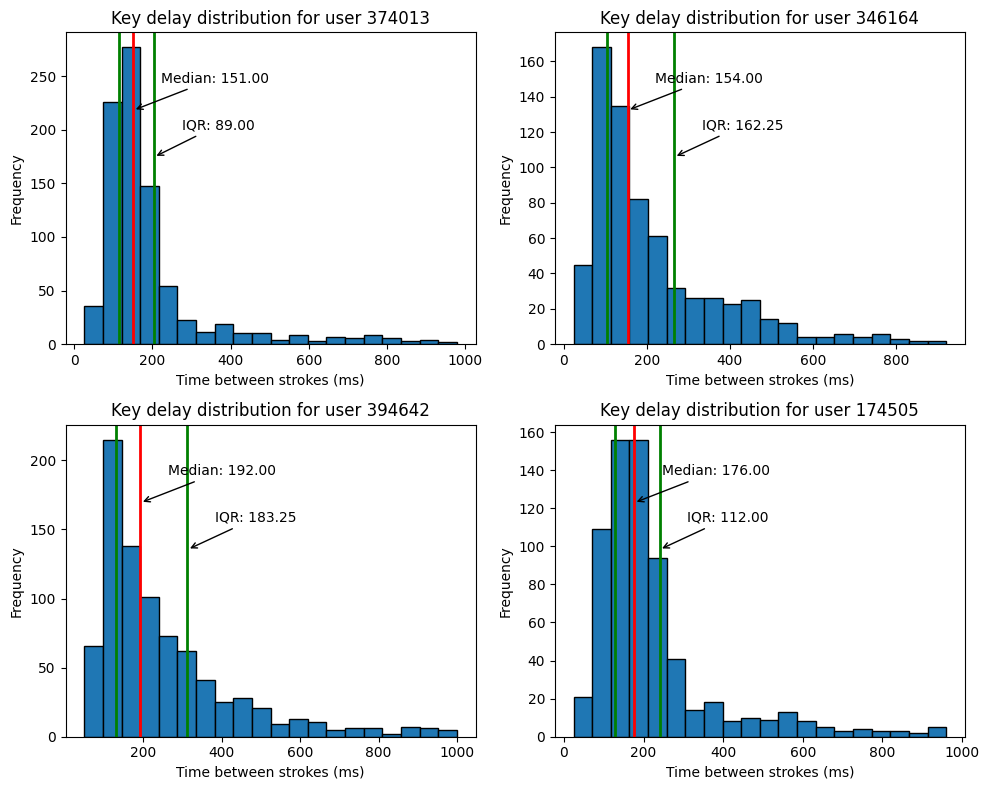

In [5]:
figure, subplot = plt.subplots(nrows=graph_row_count, ncols=graph_col_count, figsize=(graph_size_x, graph_size_y))

graph_row = 0
graph_col = 0


for file_to_show in files_to_show:
    data_frame = pd.read_csv(file_to_show, delimiter='\t')
    data_frame["KEY_DELAY"] = data_frame["PRESS_TIME"].shift(-1) - data_frame["PRESS_TIME"]
    data_frame = data_frame.query("KEY_DELAY <= 1000")
    data_frame = data_frame.query("KEY_DELAY > 0")

    first_quartile = data_frame["KEY_DELAY"].quantile(0.25)
    third_quartile = data_frame["KEY_DELAY"].quantile(0.75)
    key_delay_median = data_frame["KEY_DELAY"].median()

    
    subplot[graph_row][graph_col].hist(data_frame['KEY_DELAY'], bins=20, edgecolor='black')
    user_id = re.match(r".*/(\d+)_keystrokes.*", file_to_show).group(1)
    subplot[graph_row][graph_col].set_title(f'Key delay distribution for user {user_id}')
    subplot[graph_row][graph_col].set_xlabel('Time between strokes (ms)')
    subplot[graph_row][graph_col].set_ylabel('Frequency')

    subplot[graph_row][graph_col].axvline(key_delay_median, color='red', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'Median: {key_delay_median:.2f}', xy=(key_delay_median, 0.75), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black', 
                arrowprops=dict(arrowstyle='->', color='black'))

    subplot[graph_row][graph_col].axvline(first_quartile, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].axvline(third_quartile, color='green', linestyle='solid', linewidth=2)
    subplot[graph_row][graph_col].annotate(f'IQR: {third_quartile - first_quartile:.2f}', xy=(third_quartile, 0.60), xycoords=('data', 'axes fraction'),
                xytext=(20, 20), textcoords='offset points', color='black',
                arrowprops=dict(arrowstyle='->', color='black'))

    graph_row += 1

    if graph_row >= graph_row_count:
        graph_col += 1
        graph_row %= graph_row_count

plt.tight_layout()
plt.show()

Based on these visualizations, median / IQR seems to be a much better measure of spread and center than mean / standard deviation.

## Hypothesis Acceptance Evaluation (Part one)
Our hypothesis was that we could use the standard deviation and the mean to differentiate bot users and humans. It seems that we may need to adjust this slightly based on the visualizations above. While the mean and standard deviation were effective measures of center and spread for the key held time, the IQR and median seems to more accurately describe the distribution for key stroke delay time.

We will move forward using median / IQR for key delay and mean / standard deviation for key held time.




## Data Cleaning and Preparation

From what we found above, standard deviation and mean were good measures of center and spread for key held time, but for time between key strokes median and IQR were better. So, now we need to parse the raw data. In this project, this is done using the file(s) in DataCleaner/. A brief overview of the cleaning method follows.

1. Use the script in Data/ to download and extract the raw data.
2. Remove non-data files.
3. Parse each file and check for irregularity.
    * If a file is missing needed information, discard the sample.
    * If it is missing data, but it's unnecessary data, use the sample but take extra care when parsing.
4. Perform the numeric analysis of center and spread for applicable values on a user basis.
5. Write the results to a new file.

Now that the data has been processed, we can look at the distribution for details we can use.

## Derived Data Analysis



After the data has been cleaned and all of the derived statistics calculated, we can graph the average statistics for the population. Below are graphs for each of the statistics extracted from the data. Every data point on these graphs represent one individual's scores.

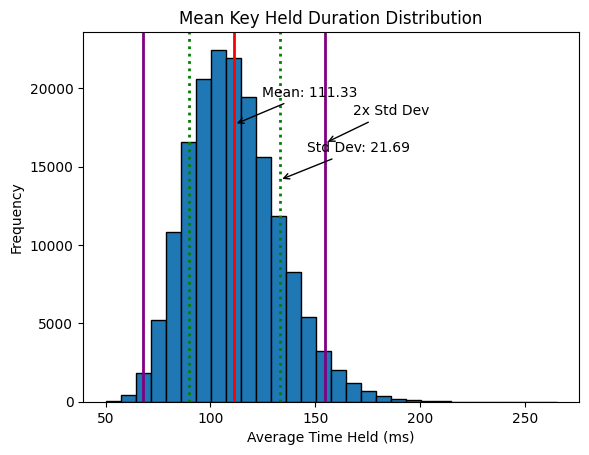

In [6]:

data_frame = pd.read_csv("../Data/processed/result.csv", delimiter=',', names=["KEY_HELD_AVG","KEY_HELD_STD_DEV","KEY_DELAY_MEDIAN","KEY_DELAY_IQR","OVERLAP_PERCENT"])

std_dev = data_frame['KEY_HELD_AVG'].std()
mean = data_frame['KEY_HELD_AVG'].mean()


plt.hist(data_frame['KEY_HELD_AVG'], bins=30, edgecolor='black')
plt.title(f'Mean Key Held Duration Distribution')
plt.xlabel('Average Time Held (ms)')
plt.ylabel('Frequency')


plt.axvline(mean, color='red', linestyle='solid', linewidth=2)
plt.annotate(f'Mean: {mean:.2f}', xy=(mean, 0.75), xycoords=('data', 'axes fraction'),
            xytext=(20, 20), textcoords='offset points', color='black', 
            arrowprops=dict(arrowstyle='->', color='black'))

plt.axvline(mean + std_dev, color='green', linestyle='dotted', linewidth=2)
plt.axvline(mean - std_dev, color='green', linestyle='dotted', linewidth=2)
plt.annotate(f'Std Dev: {std_dev:.2f}', xy=(mean + std_dev, 0.60), xycoords=('data', 'axes fraction'),
            xytext=(20, 20), textcoords='offset points', color='black',
            arrowprops=dict(arrowstyle='->', color='black'))

plt.axvline(mean + 2 * std_dev, color='purple', linestyle='solid', linewidth=2)
plt.axvline(mean - 2 * std_dev, color='purple', linestyle='solid', linewidth=2)
plt.annotate(f'2x Std Dev', xy=(mean + 2 * std_dev, 0.7), xycoords=('data', 'axes fraction'),
            xytext=(20, 20), textcoords='offset points', color='black',
            arrowprops=dict(arrowstyle='->', color='black'))


plt.show()

As the data is roughly normal, we can use the standard deviation to estimate that 95% of scores should lie within two standard deviations of the mean. These values are about 68ms and 154ms. Anything beyond this value can be considered anomalous.

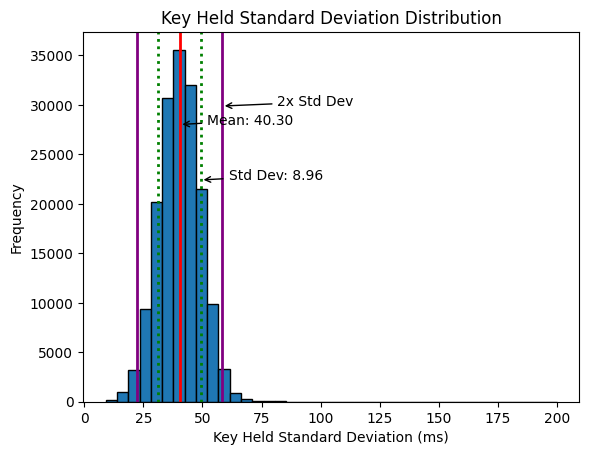

In [7]:
plt.hist(data_frame['KEY_HELD_STD_DEV'], bins=40, edgecolor='black')
plt.title(f'Key Held Standard Deviation Distribution')
plt.xlabel('Key Held Standard Deviation (ms)')
plt.ylabel('Frequency')

std_dev = data_frame['KEY_HELD_STD_DEV'].std()
mean = data_frame['KEY_HELD_STD_DEV'].mean()

plt.axvline(mean, color='red', linestyle='solid', linewidth=2)
plt.annotate(f'Mean: {mean:.2f}', xy=(mean, 0.75), xycoords=('data', 'axes fraction'),
            xytext=(20, 0), textcoords='offset points', color='black', 
            arrowprops=dict(arrowstyle='->', color='black'))

plt.axvline(mean + std_dev, color='green', linestyle='dotted', linewidth=2)
plt.axvline(mean - std_dev, color='green', linestyle='dotted', linewidth=2)
plt.annotate(f'Std Dev: {std_dev:.2f}', xy=(mean + std_dev, 0.60), xycoords=('data', 'axes fraction'),
            xytext=(20, 0), textcoords='offset points', color='black',
            arrowprops=dict(arrowstyle='->', color='black'))

plt.axvline(mean + 2 * std_dev, color='purple', linestyle='solid', linewidth=2)
plt.axvline(mean - 2 * std_dev, color='purple', linestyle='solid', linewidth=2)
plt.annotate(f'2x Std Dev', xy=(mean + 2 * std_dev, 0.80), xycoords=('data', 'axes fraction'),
            xytext=(40, 0), textcoords='offset points', color='black',
            arrowprops=dict(arrowstyle='->', color='black'))
            
plt.show()

As the data is roughly normal, we can use the standard deviation to estimate that 95% of scores should lie between about 22ms and 58ms.

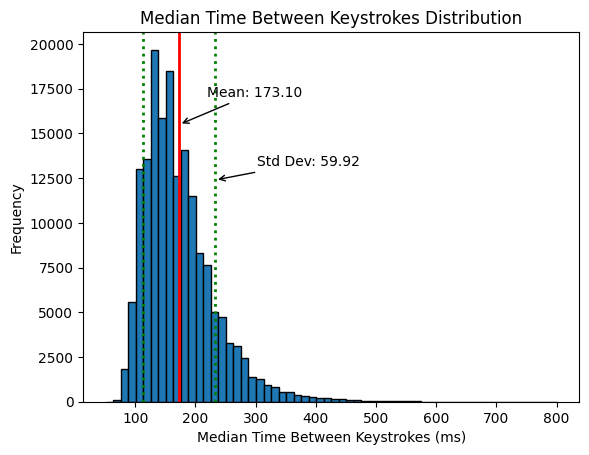

In [8]:
plt.hist(data_frame['KEY_DELAY_MEDIAN'], bins=60, edgecolor='black')
plt.title(f'Median Time Between Keystrokes Distribution')
plt.xlabel('Median Time Between Keystrokes (ms)')
plt.ylabel('Frequency')

std_dev = data_frame['KEY_DELAY_MEDIAN'].std()
mean = data_frame['KEY_DELAY_MEDIAN'].mean()

plt.axvline(mean, color='red', linestyle='solid', linewidth=2)
plt.annotate(f'Mean: {mean:.2f}', xy=(mean, 0.75), xycoords=('data', 'axes fraction'),
            xytext=(20, 20), textcoords='offset points', color='black', 
            arrowprops=dict(arrowstyle='->', color='black'))

plt.axvline(mean + std_dev, color='green', linestyle='dotted', linewidth=2)
plt.axvline(mean - std_dev, color='green', linestyle='dotted', linewidth=2)
plt.annotate(f'Std Dev: {std_dev:.2f}', xy=(mean + std_dev, 0.60), xycoords=('data', 'axes fraction'),
            xytext=(30, 10), textcoords='offset points', color='black',
            arrowprops=dict(arrowstyle='->', color='black'))



plt.show()

The distribution for this has a positive skew. Our 95% rule won't work well here. Visually, we see that the average typist types with between ~100ms and ~300ms delay between their strokes. With some quick algebra, the values become ~600 to ~200 keystrokes per minute for the majority of typists.

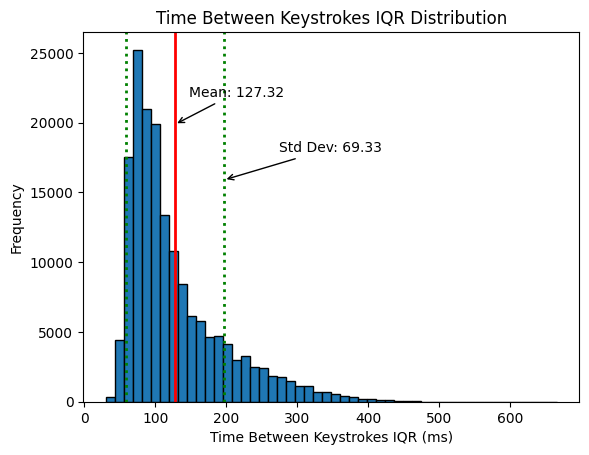

In [9]:
plt.hist(data_frame['KEY_DELAY_IQR'], bins=50, edgecolor='black')
plt.title(f'Time Between Keystrokes IQR Distribution')
plt.xlabel('Time Between Keystrokes IQR (ms)')
plt.ylabel('Frequency')

std_dev = data_frame['KEY_DELAY_IQR'].std()
mean = data_frame['KEY_DELAY_IQR'].mean()

plt.axvline(mean, color='red', linestyle='solid', linewidth=2)
plt.annotate(f'Mean: {mean:.2f}', xy=(mean, 0.75), xycoords=('data', 'axes fraction'),
            xytext=(10, 20), textcoords='offset points', color='black', 
            arrowprops=dict(arrowstyle='->', color='black'))

plt.axvline(mean + std_dev, color='green', linestyle='dotted', linewidth=2)
plt.axvline(mean - std_dev, color='green', linestyle='dotted', linewidth=2)
plt.annotate(f'Std Dev: {std_dev:.2f}', xy=(mean + std_dev, 0.60), xycoords=('data', 'axes fraction'),
            xytext=(40, 20), textcoords='offset points', color='black',
            arrowprops=dict(arrowstyle='->', color='black'))


plt.show()

We can observe a good curve here that shows the variation in IQR across the samples. While we can't use our standard deviation trick here either, we can see that the typical values for a standard typist is between about 50ms and 350ms.

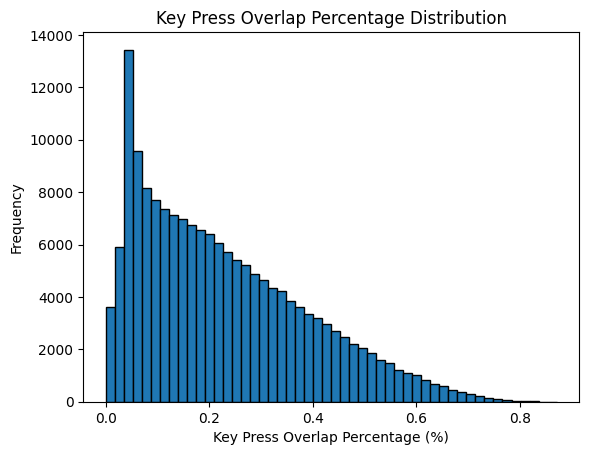

In [10]:

plt.hist(data_frame['OVERLAP_PERCENT'], bins=50, edgecolor='black')
plt.title(f'Key Press Overlap Percentage Distribution')
plt.xlabel('Key Press Overlap Percentage (%)')
plt.ylabel('Frequency')

plt.show()

This statistic doesn't immediately tell us much. It appears that it is common that at least some real users do not overlap their keys when they type. Howwever, let's view the relationship between typing speed (median key stroke time) and overlap percentage:


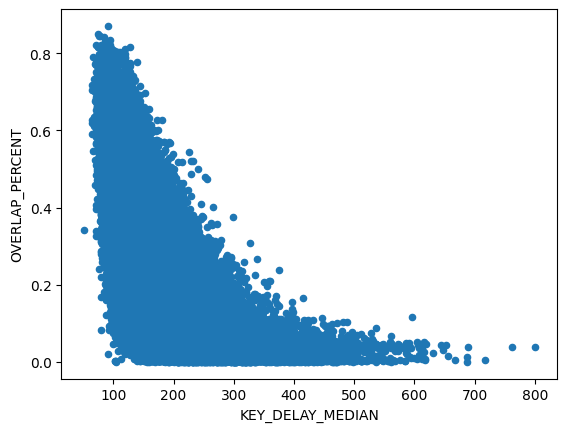

In [11]:
data_frame.plot.scatter(x="KEY_DELAY_MEDIAN" ,y="OVERLAP_PERCENT")
plt.show()

As you can see, there *is* a relationship. From this we can make two statements:
* The slower that a user types, the less likely they are to overlap keys. The inverse is not necessarily true.
* Users that type fast may or may not overlap keys much, but rarely have *no* overlap.

While for fast typists this doesn't mean much, we can identify any score with high overlap but slow speed as an outlier. Additionally, extremely high typing speed but near zero overlap is also uncommon.

### Derived Data Analysis Conclusion

From our analysis we can make the following generalizations about typical typists:

* They typically hold their keys on average 68-154ms.
* The standard deviation for that value should be between 22-58ms.
* Their typing speed is typically on the order of about 200-600 strokes per minute.
* The standard deviation in typing speed during a session varies significantly. But, it should in general be between 50-350ms.
* Fast typists oftentimes do, but sometimes don't overlap their key presses. Slow typists almost never do.

## Hypothesis Acceptance Evaluation (Part two)

For convenience, the original hypothesis is below:

> Users can successfully be distinguished from a large class of bots based on the typing metrics of `average key held time`, `average keystroke delay time`, `key overlap percentage` and `standard deviation of the first two values` using unsupervised machine learning techniques.

Through our analysis, we have found that the metrics of `average key held time` and `standard deviation of key held time` seems to be a consistent across many users.
We found that the `median / IQR` was better suited for the key stroke delay than `mean / standard deviation`, but that it was also a consistent across many users.
Lastly, `overlap percentage` varies greatly among typists. We did find however, a very stark trend indicating that one could identify an anomaly if the key overlap was high but the typing speed was low.

In order to finish evaluating our hypothesis, we need to use an unsupervised machine learning technique. Our data points for this set consist of five points each. As far as dimmensionality, this is reasonably low. Further, we want to detect anomalies. One unsupervised machine learning algorithm that works well with low dimmensionality data and is good at identifying outliers is the Local Outlier Factor (LOF) algorithm. We will implement a model for this and begin tuning the hyper parameters.

## Hyper Parameter Tuning

We will be using Scikit Learn's implementation of the LOF algorithm. The hyper parameters we will use for this are `n_neighbors` and `contamination`.

Additionally, `novelty` will be set to `True` so that we can use the model for novelty detection on unseen data.

To tune, we used two metrics:
1. How accurately can it identify bot users? 
2. How accurately can it identify human users?

For both of these metrics, we will use the score from the `decision_function()` to optimize the model. A higher score (positive) indicates it is more likely an inlier. A lower score (negative) indicates an outlier. Zero is the threshold as defined by the library for inlier/outlier decisions.

To gather simulated bot data, we will use Puppeteer to access a text field that collects key stroke data. It will then try four different methods for key input. For human data, we will use a portion of the training data that was separated by the `train_test_split()` function.

The results of these tests are as follows:

| Test Case                                                | C(0.01), N(100) | C(0.01), N(50) | C(0.001), N(100) | C(0.001), N(50) |
|----------------------------------------------------------|-----------------|----------------|------------------|-----------------|
| Puppeteer (Instant Typing) [Score]                       | -7.689          | -7.958         | -7.045           | -7.194          |
| Puppeteer (Constant Delay) [Score]                       | -3.974          | -4.067         | -3.283           | -3.475          |
| Puppeteer (Slight Variable Delay) [Score]                | -2.862          | -2.886         | -2.205           | -2.253          |
| Puppeteer (Significantly Varied Delay) [Score]           | -2.426          | -2.670         | -1.772           | -2.120          |
| Sample Data (Human User Data) [Average Score, Std. Dev.] | 0.338, 0.102    | 0.318, 0.088   | 1.003, 0.102     | 0.943, 0.088    |

From these tests we can see that the contamination factor has a large impact on the scores. Both of the models with a contamination of 0.001 flag good data near 1.0 much more often than than the models with 0.01 contamination. Further, increasing the number of neighbors seems to yield higher scores in general. In general, we want to maximize the positive score so as to flag human users as non humans as infrequently as possible, even at the cost of a higher false negative rate. For this reason, we will select a `contamination` value of 0.001 and a `n_neighbors` of 100.

## Hypothesis Acceptance Evaluation (Part three)

As we can see from the table above, the automated bot script scored very low. Far below the threshold for rejection, which is any negative value. Further, humans scored well. To get full picture of its functionality one would have to conduct a trial with human participants. Though not adequate for a full study, I was able to score decently with this model as well.

| Trial Number | Score  |
|--------------|--------|
| 1            | 0.968  |
| 2            | 1.054  |
| 3            | 0.731  |
| 4            | 1.035  |
| 5            | -0.043 |
| 6            | 0.990  |
| 7            | 0.889  |
| 8            | 0.970  |
| 9            | 0.199  |
| 10           | -0.216 |

It is worth noting that test numbers 5 and 10 were technically failures. On these tests I had to go back and fix errors with arrow keys and pause before continuing. Additionally, I scored rather low for test number 9. This particular test was the shortest sentence of all of the inputs. It is possible that without a sufficiently long input, the values for spread and center are not accurate enough. Regardless, even the poorest scoring of my attempts did not come close to the nearest bot attempt.

I think that the automated tests and my brief trials are enough to tentatively mark the hypothesis as a success. However, as mentioned in the other hypothesis evaluation sections, standard deviation and mean were not a good measure for center and spread for key input delay.

Then, the conclusion we can draw is something more like this:

> Users can successfully be distinguished from a large class of bots based on the typing metrics of `average key held time`, `median keystroke delay time`, `key overlap percentage`, `standard deviation of key held time` and `interquartile range of key delay time` using unsupervised machine learning techniques.

